In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from collections import OrderedDict
import pdb
import pickle

In [32]:
%reload_ext watermark
%watermark -a "Moon Jeong-Hyeon" -u -d -p numpy,pandas,matplotlib,sklearn

Author: Moon Jeong-Hyeon

Last updated: 2020-12-02

numpy     : 1.19.3
pandas    : 1.1.4
matplotlib: 3.3.3
sklearn   : 0.23.2



# Data

In [33]:
mnist_sci = fetch_openml('mnist_784')

In [34]:
x_train, x_test, y_train_, y_test_ = train_test_split(mnist_sci.data, mnist_sci.target, 
                                                    test_size = 0.1,
                                                   shuffle = True)
x_train /= 255.0
x_test /= 255.0
x_train = x_train.reshape(-1,1,28,28)
x_test = x_test.reshape(-1,1,28,28)

def one_hoy_label(X):
    T = np.zeros((X.size, 10))    
    for idx, row in enumerate(T):
        row[int(X[idx])] = 1
        
    return T

y_train = one_hoy_label(y_train_)
y_test = one_hoy_label(y_test_)

# optimizer

In [35]:
class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)


# Trainer

In [36]:


class Trainer:
    """신경망 훈련을 대신 해주는 클래스
    """
    def __init__(self, network, x_train, t_train, x_test, t_test,
                 epochs=20, mini_batch_size=100,
                 optimizer='SGD', optimizer_param={'lr':0.01}, 
                 evaluate_sample_num_per_epoch=None, verbose=True):
        self.network = network
        self.verbose = verbose
        self.x_train = x_train
        self.t_train = t_train
        self.x_test = x_test
        self.t_test = t_test
        self.epochs = epochs
        self.batch_size = mini_batch_size
        self.evaluate_sample_num_per_epoch = evaluate_sample_num_per_epoch

        # optimzer
        optimizer_class_dict = {'adam':Adam}
        self.optimizer = optimizer_class_dict[optimizer.lower()](**optimizer_param)
        
        self.train_size = x_train.shape[0]
        self.iter_per_epoch = max(self.train_size / mini_batch_size, 1)
        self.max_iter = int(epochs * self.iter_per_epoch)
        self.current_iter = 0
        self.current_epoch = 0
        
        self.train_loss_list = []
        self.train_acc_list = []
        self.test_acc_list = []

    def train_step(self):
        batch_mask = np.random.choice(self.train_size, self.batch_size)
        x_batch = self.x_train[batch_mask]
        t_batch = self.t_train[batch_mask]
        
        grads = self.network.gradient(x_batch, t_batch)
        self.optimizer.update(self.network.params, grads)
        
        loss = self.network.loss(x_batch, t_batch)
        self.train_loss_list.append(loss)
        if self.verbose: print("train loss:" + str(loss))
        
        if self.current_iter % self.iter_per_epoch == 0:
            self.current_epoch += 1
            
            x_train_sample, t_train_sample = self.x_train, self.t_train
            x_test_sample, t_test_sample = self.x_test, self.t_test
            if not self.evaluate_sample_num_per_epoch is None:
                t = self.evaluate_sample_num_per_epoch
                x_train_sample, t_train_sample = self.x_train[:t], self.t_train[:t]
                x_test_sample, t_test_sample = self.x_test[:t], self.t_test[:t]
                
            train_acc = self.network.accuracy(x_train_sample, t_train_sample)
            test_acc = self.network.accuracy(x_test_sample, t_test_sample)
            self.train_acc_list.append(train_acc)
            self.test_acc_list.append(test_acc)

            if self.verbose: print("=== epoch:" + str(self.current_epoch) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc) + " ===")
        self.current_iter += 1

    def train(self):
        for i in range(self.max_iter):
            self.train_step()

        test_acc = self.network.accuracy(self.x_test, self.t_test)

        if self.verbose:
            print("=============== Final Test Accuracy ===============")
            print("test acc:" + str(test_acc))



# util 

In [37]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """다수의 이미지를 입력받아 2차원 배열로 변환한다(평탄화).
    
    Parameters
    ----------
    input_data : 4차원 배열 형태의 입력 데이터(이미지 수, 채널 수, 높이, 너비)
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns
    -------
    col : 2차원 배열
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))
#     pdb.set_trace()
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col


def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """(im2col과 반대) 2차원 배열을 입력받아 다수의 이미지 묶음으로 변환한다.
    
    Parameters
    ----------
    col : 2차원 배열(입력 데이터)
    input_shape : 원래 이미지 데이터의 형상（예：(10, 1, 28, 28)）
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns
    -------
    img : 변환된 이미지들
    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]


def identity_function(x):
    return x


def step_function(x):
    return np.array(x > 0, dtype=np.int)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))    


def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)
    

def relu(x):
    return np.maximum(0, x)


def relu_grad(x):
    grad = np.zeros(x)
    grad[x>=0] = 1
    return grad

def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))


def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


def softmax_loss(X, t):
    y = softmax(X)
    return cross_entropy_error(y, t)

# Base layer

In [38]:
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx


class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = sigmoid(x)
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx


class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 가중치와 편향 매개변수의 미분
        self.dW = None
        self.db = None

    def forward(self, x):
        # 텐서 대응
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)  # 입력 데이터 모양 변경(텐서 대응)
        return dx


class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 손실함수
        self.y = None    # softmax의 출력
        self.t = None    # 정답 레이블(원-핫 인코딩 형태)
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 정답 레이블이 원-핫 인코딩 형태일 때
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx

# Conv & Pooling

In [39]:
class Convolution:
    def __init__(self, W, b, prob, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        self.prob = prob

        # 중간 데이터（backward 시 사용）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # 가중치와 편향 매개변수의 기울기
        self.dW = None
        self.db = None

        
    def forward(self, x):
        if np.random.normal() > self.prob:
            return self.__forward_col(x)
        else: 
            col_ = self.__forward_col(x)
            for_ = self.__forward_for(x)

            if np.sum(col_ - for_) > 0.1:                               
                raise Exception('error')  

            FN, C, FH, FW = self.W.shape
            nx = 8
            ny = int(np.ceil(FN / nx))

            fig = plt.figure()
            fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

            for i in range(3):
                ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
                ax.imshow(self.W[i, 0], cmap=plt.cm.gray_r)
                print(self.W[i, 0,0,1])
            plt.show()
    
    
            return self.__forward_for(x)

    def __forward_col(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T

        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        self.x = x
        self.col = col
        self.col_W = col_W

        return out
    
    # 2-2 Convolution(forward) 구현
    def __forward_for(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape

        # out size 계산
        out_h = 1 + int((H + 2 * self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2 * self.pad - FW) / self.stride)

        # padding
        x_pad = np.pad(x, ((0, 0), (0, 0), (self.pad, self.pad), (self.pad, self.pad)), 'constant', constant_values=0)

        # out 초기화
        out = np.zeros((N, FN, out_h, out_w))

        for n in range(N):
            for f in range(FN):
                for h in range(out_h):
                    for w in range(out_w):
                        # input의 모든 index에 Filter W를 컨볼루션 진행
                        result = x_pad[n, :, (h * self.stride):(h * self.stride + FH), (w * self.stride):(w * self.stride + FW)] * self.W[f]

                        # bias 추가 및 out에 저장
                        out[n][f][h][w] += np.sum(result) + self.b[f]
        return out
        
    def backward(self, x):
        if np.random.normal() > self.prob:
            return self.__backward_col(x)
        else: 
            col_ = self.__backward_col(x)
            for_ = self.__backward_for(x)

            if np.sum(col_ - for_) > 0.1:                               
                raise Exception('error')  

                
            return self.__backward_col(x)    


    def __backward_col(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx
    
    def __backward_for(self, dout):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = self.x.shape
        out_h = 1 + int((H + 2 * self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2 * self.pad - FW) / self.stride)

        # padding
        x_pad = np.pad(self.x, ((0, 0), (0, 0), (self.pad, self.pad), (self.pad, self.pad)), "constant", constant_values=0)

        # gradient 변수들 초기화
        dx = np.zeros(x_pad.shape)
        dw = np.zeros(self.W.shape)
        db = np.zeros(self.b.shape)

        for n in range(N):
            for f in range(FN):
                for h in range(out_h):
                    for w in range(out_w):
                        # Filter에 대한 gradient 계산 및 저장
                        dw[f] += x_pad[n, : , h * self.stride : h * self.stride + FH, w * self.stride: w * self.stride + FW] * dout[n][f][h][w]
                        # input에 대한 gradient 계산 및 저장
                        dx[n, :, h * self.stride: h * self.stride + FH, w * self.stride: w * self.stride + FW] += self.W[f] * dout[n, f, h, w]
                # bias에 대한 gradient 계산 및 저장
                db[f] = np.sum(dout[n,f,:,:])

        # remove padding
        dx = dx[:, :, self.pad:dx.shape[2]-self.pad, self.pad:dx.shape[3]-self.pad]

        # 이후 gradient 사용을 위해 class의 변수에 저장
        self.db = db
        self.dW = dw

        return dx


class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0, prob = -12.5):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.prob = prob

        self.x = None
        self.arg_max = None
        
        
    def forward(self, x):
        if np.random.normal() > self.prob:
            return self.__forward_col(x)
        else: 
            col_ = self.__forward_col(x)
            for_ = self.__forward_for(x)

            if np.sum(col_ - for_) > 0.1:                               
                raise Exception('error')      
    
            return self.__forward_for(x)
    
    def backward(self, x):
        if np.random.normal() > self.prob:
            return self.__backward_col(x)
        else: 
            col_ = self.__backward_col(x)
            for_ = self.__backward_for(x)

            if np.sum(col_ - for_) > 0.1:                               
                raise Exception('error')  

                
            return self.__backward_col(x)    
    

    def __forward_col(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out
    
    # 2-3 Pooling(forward) 구현
    def __forward_for(self, x):
        N, C, H, W = x.shape

        # 출력 사이즈 계산
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        # 출력 변수 초기화
        out = np.zeros((N, C, out_h, out_w))

        for h in range(out_h):
            for w in range(out_w):
                # maxpooling 진행
                out[:, :, h, w] = np.max(self.x[:, :, (h * self.stride):(h * self.stride + self.pool_h), (w * self.stride):(w * self.stride + self.pool_w)])

        return out

    def __backward_col(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx
    
    # 2-3 Pooling(backward) 구현
    def __backward_for(self, dout):
        N, C, H, W = self.x.shape

        # dout의 사이즈 계산
        out_h = (H-self.pool_h) // self.stride + 1
        out_w = (W-self.pool_w) // self.stride + 1
        print(dout.shape, out_h, out_w)

        # dx 초기화
        dx = np.zeros(self.x.shape)

        for n in range(N):
            for c in range(C):
                for h in range(out_h):
                    for w in range(out_w):
                        # gradient 계산
                        arr = self.x[n, c, (w * self.stride):(w * self.stride + self.pool_h), (h * self.stride):(h * self.stride + self.pool_w)]
                        idx = np.nanargmax(arr)
                        (arr_w, arr_h) = np.unravel_index(idx, arr.shape)

                        # gradient 저장
                        dx[n][c][w * self.stride + arr_w][h * self.stride + arr_h] = dout[n][c][w][h]
        return dx

In [40]:
class SimpleConvNet:
    """단순한 합성곱 신경망
    
    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    """
    def __init__(self, input_dim=(1, 28, 28), prob = -12.5,
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'], prob,
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2, prob = prob)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        # 2-1 Gradient 구현

        # backward 진행을 위해 layer의 순서를 반전
        layers = list(self.layers.values())
        layers.reverse()

        # 각 layer의 backward 진행을 통해 dout 갱신
        for layer in layers:
            dout = layer.backward(dout)

        # 각 layer의 weight, bias의 gradient 값을 저장 후 반환
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]


train loss:2.302179953117573
=== epoch:1, train acc:0.234375, test acc:0.25 ===
train loss:2.3017151087299625
train loss:2.3011094295525427
train loss:2.3001642597057343
train loss:2.2991552669659
0.009670146758968944
0.0169359698759208
0.0061210893343972275
train loss:2.297442221619387
train loss:2.295836917390992
train loss:2.2930782229143856
train loss:2.2914659774532393
train loss:2.2880161410000066
train loss:2.2833997839608955
train loss:2.2789633498732687
train loss:2.273302398397603
train loss:2.2692440317711937
train loss:2.264175320336337
train loss:2.3127335633447013
train loss:2.2495026746225433
train loss:2.237864552727742
train loss:2.2328182709196343
train loss:2.2223260585918196
train loss:2.2109138408619784
train loss:2.2010967696525063
train loss:2.188521737119941
train loss:2.170357854264582
train loss:2.1582141054866018
train loss:2.1406285202290003
train loss:2.1121246885619547
train loss:2.092947609166544
train loss:2.07506894144861
train loss:2.044888528663276
tr

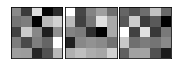

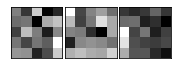

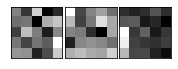

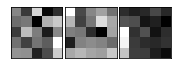

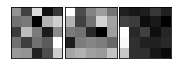

In [ ]:
max_epochs = 5
network = SimpleConvNet(input_dim=(1,28,28), prob = -2, 
                        conv_param = {'filter_num': 10, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, y_train, x_test, y_test,
                  epochs=max_epochs, mini_batch_size=1000,
                  optimizer='Adam', optimizer_param={'lr': 0.0005},
                  evaluate_sample_num_per_epoch=128)
trainer.train()

